## Data Prep, EDA & Feature Selection

In [250]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, VotingRegressor, VotingClassifier
from sklearn.svm import SVC, SVR
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score

from sklearn.pipeline import Pipeline

def plot_matrix(y_true,y_pred,title):
    cf_matrix= confusion_matrix(y_true, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues').set(title = title)
    
    return ax

In [216]:
# Read the data
data = pd.read_csv("04_08_finwlabel.csv")
data.head()

/var/folders/l5/p84y__wd0xvdh_zxygx76q900000gn/T/ipykernel_68216/2460825700.py:2: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("04_08_finwlabel.csv")


,RCON1594,RCONB993,RIAD4518,RCON1255,RCON5400,RCON1254,RIAD4012,RIAD4507,RCON3545,RCONB834,...,Reporting Period End Date,OCC Charter Number,OTS Docket Number,Primary ABA Routing Number,Financial Institution Filing Type,CERT,date,date_index,last,survival
0,0.0,0,1.0,NaN,0,NaN,99,86,0.0,0.0,...,2004-03-31,0.0,15876.0,104908422.0,41.0,1434,2004-03-31,1,20.0,0.836963
1,0.0,0,0.0,NaN,0,NaN,14,38,0.0,0.0,...,2004-03-31,0.0,0.0,101209768.0,41.0,9377,2004-03-31,1,20.0,0.836963
2,0.0,0,6.0,NaN,0,NaN,31,0,0.0,0.0,...,2004-03-31,0.0,0.0,102104273.0,41.0,15759,2004-03-31,1,20.0,0.836963
3,0.0,571,18.0,NaN,0,NaN,238,53,0.0,0.0,...,2004-03-31,24484.0,14965.0,74913660.0,41.0,18927,2004-03-31,1,13.0,0.008934
4,0.0,0,0.0,NaN,0,NaN,9,8,0.0,0.0,...,2004-03-31,0.0,0.0,81505964.0,41.0,16959,2004-03-31,1,20.0,0.836963


In [217]:
# Do Feature Selection
# Exclude the specified columns
exclude_columns = ['Reporting Period End Date', 'OCC Charter Number', 'OTS Docket Number',
                   'Primary ABA Routing Number', 'Financial Institution Filing Type', 'CERT', 'date',
                   'date_index', 'last', 'survival','IDRSSD.1','RIAD9106']

feature_columns = [col for col in data.columns if col not in exclude_columns]

# Select rows based on date_index for training and prediction
train_data = data[data['date_index'].isin([1, 6, 11, 16])].reset_index(drop=True)

# Drop columns with more than 10% NAs
columns_with_too_many_nas = train_data.columns[train_data.isna().mean() > 0.1]
train_data = train_data.drop(columns_with_too_many_nas, axis=1)

# Update feature_columns to only include columns that were not dropped
feature_columns = [col for col in feature_columns if col not in columns_with_too_many_nas]

# Fill remaining NAs with 0
train_data.fillna(0, inplace=True)

# Select a subset of train_data for feature selection
train_data_subset = train_data.sample(frac=0.005, random_state=42)

# Feature selection using Recursive Feature Elimination with Cross-Validation (RFECV)
cv = TimeSeriesSplit(n_splits=5)
rfecv = RFECV(RandomForestRegressor(random_state=42), step=1, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
rfecv.fit(train_data_subset[feature_columns], train_data_subset['last'])

# Select the top 15 features based on the feature importances
feature_importances = rfecv.estimator_.feature_importances_
sorted_features = sorted(zip(feature_columns, feature_importances), key=lambda x: x[1], reverse=True)
selected_features = [feature[0] for feature in sorted_features[:15]]
print(f'Selected features: {selected_features}')

Selected features: ['RCONB835', 'RIAD4180', 'RCON3505', 'RCON2150', 'RCON5400', 'RCON3499', 'RCON2930', 'RCON6558', 'RCONB528', 'RCONB576', 'RIAD4513', 'RCON3495', 'RCON2160', 'RCON5369', 'RIAD4301']


In [218]:
pd.DataFrame(sorted_features).iloc[:15,:].rename(columns={0:'Feature_Name',1:'Feature Importance'})

,Feature_Name,Feature Importance
0,RCONB835,0.046689
1,RIAD4180,0.042347
2,RCON3505,0.038669
3,RCON2150,0.034910
4,RCON5400,0.032947
5,RCON3499,0.032187
6,RCON2930,0.031613
7,RCON6558,0.031583
8,RCONB528,0.030098
9,RCONB576,0.028732


In [219]:
# Get Features flattened [X]
def flatten_data(data, date_indices):
    flattened_data = []

    for _, group in data.groupby('CERT'):
        flattened_row = {'CERT': group['CERT'].iloc[0]}

        for index in date_indices:
            index_data = group[group['date_index'] == index]
            if not index_data.empty:
                for feature in selected_features:
                    flattened_row[f'{feature}_{index}'] = index_data[feature].values[0]

        flattened_data.append(flattened_row)

    return pd.DataFrame(flattened_data)


# Flatten the data and keep only the selected features, sliding windows
X = flatten_data(data[selected_features + ['CERT', 'date_index']], [1, 6, 11, 16])

In [220]:
# Get target variable
y = data[['CERT','last']]
idx = y.groupby(['CERT'])['last'].idxmax()
y = y.loc[idx]
y['survived'] = y['last'] == 20

In [221]:
all_data = X.merge(y)
all_data

,CERT,RCONB835_1,RIAD4180_1,RCON3505_1,RCON2150_1,RCON5400_1,RCON3499_1,RCON2930_1,RCON6558_1,RCONB528_1,...,RCON6558_16,RCONB528_16,RCONB576_16,RIAD4513_16,RCON3495_16,RCON2160_16,RCON5369_16,RIAD4301_16,last,survived
0,9,0.0,0.0,0.0,0.0,11.0,0.0,6024.0,0.0,279099.0,...,0.0,373378.0,0.0,773.0,0.0,23311.0,0.0,2567.0,16.0,False
1,14,NaN,30556.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,17290.0,0.0,NaN,NaN,1896127.0,20.0,True
2,35,0.0,10.0,0.0,234.0,0.0,0.0,5355.0,0.0,247877.0,...,0.0,322411.0,0.0,340.0,0.0,28420.0,2978.0,9774.0,20.0,True
3,39,0.0,0.0,0.0,118.0,0.0,0.0,688.0,0.0,159904.0,...,0.0,157078.0,0.0,0.0,0.0,5124.0,0.0,4273.0,20.0,True
4,41,0.0,0.0,0.0,562.0,0.0,0.0,1530.0,0.0,65508.0,...,0.0,90274.0,0.0,0.0,0.0,8962.0,0.0,3219.0,20.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8950,91280,0.0,0.0,0.0,2171.0,0.0,0.0,574.0,0.0,62948.0,...,0.0,93392.0,0.0,0.0,0.0,2319.0,7239.0,1295.0,20.0,True
8951,91322,0.0,407.0,0.0,0.0,0.0,0.0,247419.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38453.0,0.0,22919.0,18.0,False
8952,91324,0.0,0.0,0.0,0.0,0.0,0.0,33871.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,False
8953,91325,0.0,0.0,0.0,0.0,0.0,0.0,5607.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,19335.0,0.0,10773.0,20.0,True


In [222]:
# Do Imputations
import numpy as np
# Get the list of columns
relevant_columns = [col for col in all_data.columns if '_' in col]

for col in relevant_columns:
    # Get the date_index for the current column
    date_index = int(col.split('_')[1])

    # Calculate the median for the current column
    median = all_data[col].median()

    # Define a condition to check if the date_index is less than or equal to 'last'
    condition = all_data['last'] >= date_index


    # Impute the median for the rows that meet the condition
    all_data.loc[condition, col] = all_data.loc[condition, col].fillna(median)

    # Fill the remaining missing values with 0
    all_data[col] = all_data[col].fillna(0)



## Model Evaluations

In [223]:
# Split the DataFrame into train and test sets
train_ratio = 0.8
test_ratio = 1 - train_ratio
train_data, test_data = train_test_split(all_data, test_size=test_ratio, random_state=42)

### Regressor

In [224]:
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(['CERT', 'last','survived'], axis=1),
                                                  train_data[['last']],
                                                  test_size=0.2, random_state=42)


In [225]:
# Assuming train_data is already defined
# Perform train/validation split

# Define the base models
base_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR":SVR()
}

# Train and evaluate the base models
mse_results = {}
for model_name, model in base_models.items():
    # Train the model
    model.fit(X_train, y_train.values.ravel())
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_val, y_pred)
    
    # Store the results
    mse_results[model_name] = mse


selected_models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Create an ensemble model using the VotingRegressor
ensemble_model = VotingRegressor(estimators=list(selected_models.items()), n_jobs=-1)
ensemble_model.fit(X_train, y_train.values.ravel())
y_pred = ensemble_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mse_results["Ensemble Model"] = mse

# Compare the models' MSEs
print("Mean Squared Errors:")
for model_name, mse in mse_results.items():
    print(f"{model_name}: {mse}")


Mean Squared Errors:
Linear Regression: 19.567253974319623
Decision Tree: 0.9979064898813678
Random Forest: 0.5665581995812979
Gradient Boosting: 0.521104744771657
SVR: 19.07121579569027
Ensemble Model: 0.5328477090330067


Test Accuracy: 0.847571189279732


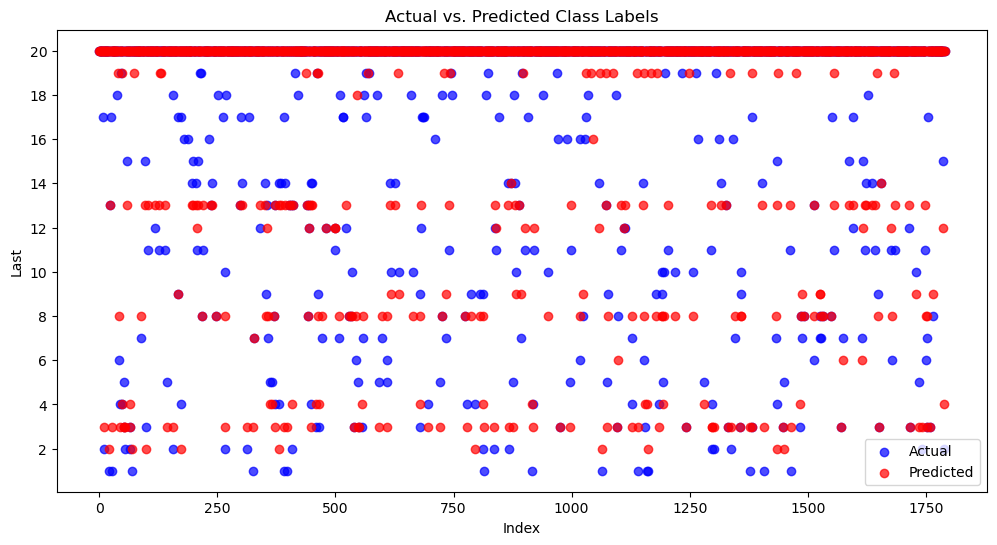

In [226]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_data is already defined
# Separate the features and target variable from the test_data
X_test = test_data.drop(['CERT','survived','last'], axis=1)
y_test = test_data[['last']]

# Use the best model (Gradient Boosting) to make predictions on the test data
best_model = ensemble_model
y_pred = best_model.predict(X_test)
y_pred = [round(i) for i in y_pred]

# Calculate the accuracy for the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Create a plot to visualize the difference between actual and predicted values
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7)
plt.scatter(np.arange(len(y_test)), y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Last')
plt.title('Actual vs. Predicted Class Labels')
plt.legend()

# Set the y-axis ticks
plt.yticks(range(2, 21, 2))

# Display the plot
plt.show()

Note that the regressors do not work well.

### Multi-Classifiers

In [227]:

# Define the base models
base_models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(random_state=42)
}

# Train and evaluate the base models
accuracy_results = {}
for model_name, model in base_models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    # Store the results
    accuracy_results[model_name] = accuracy

selected_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Create an ensemble model using the VotingClassifier
ensemble_model = VotingClassifier(estimators=list(selected_models.items()), n_jobs=-1)
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
accuracy_results["Ensemble Model"] = accuracy

# Compare the models' accuracies
print("Accuracies:")
for model_name, accuracy in accuracy_results.items():
    print(f"{model_name}: {accuracy}")


/opt/homebrew/Caskroom/miniforge/base/envs/anly501/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/anly501/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/l5/p84y__wd0xvdh_zxygx76q900000gn/T/ipykernel_68216/3108956856.py:14: DataConversionWarning: A column-vector y was passed when a 1d a

Accuracies:
Logistic Regression: 0.8653175157013259
Decision Tree: 0.8367062107466853
Random Forest: 0.8722958827634334
Gradient Boosting: 0.8513607815771109
SVC: 0.840195394277739
Ensemble Model: 0.8520586182833217


/var/folders/l5/p84y__wd0xvdh_zxygx76q900000gn/T/ipykernel_68216/2694640127.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Test Accuracy: 0.8732551647124511


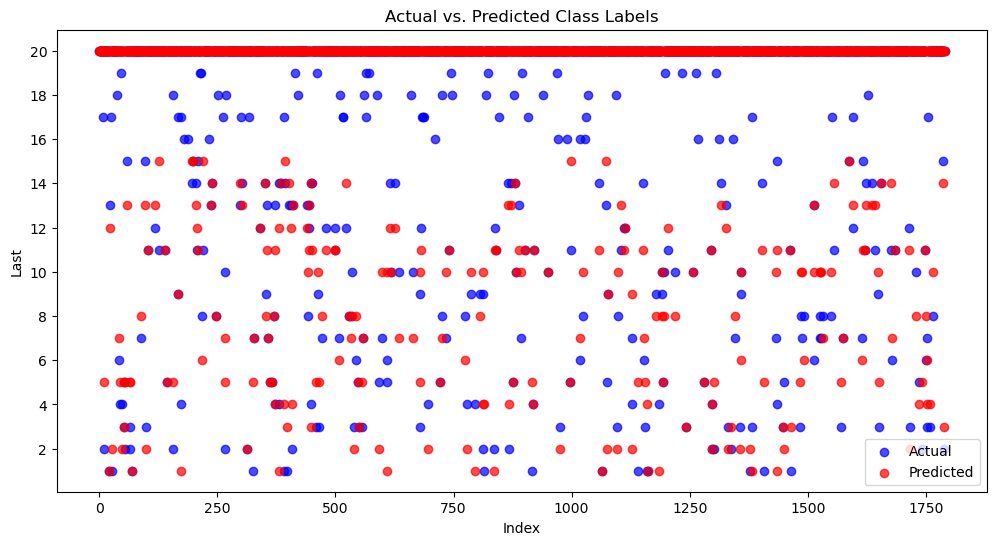

In [228]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate the accuracy for the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Create a plot to visualize the difference between actual and predicted values
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7)
plt.scatter(np.arange(len(y_test)), y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Last')
plt.title('Actual vs. Predicted Class Labels')
plt.legend()

# Set the y-axis ticks
plt.yticks(range(2, 21, 2))

# Display the plot
plt.show()

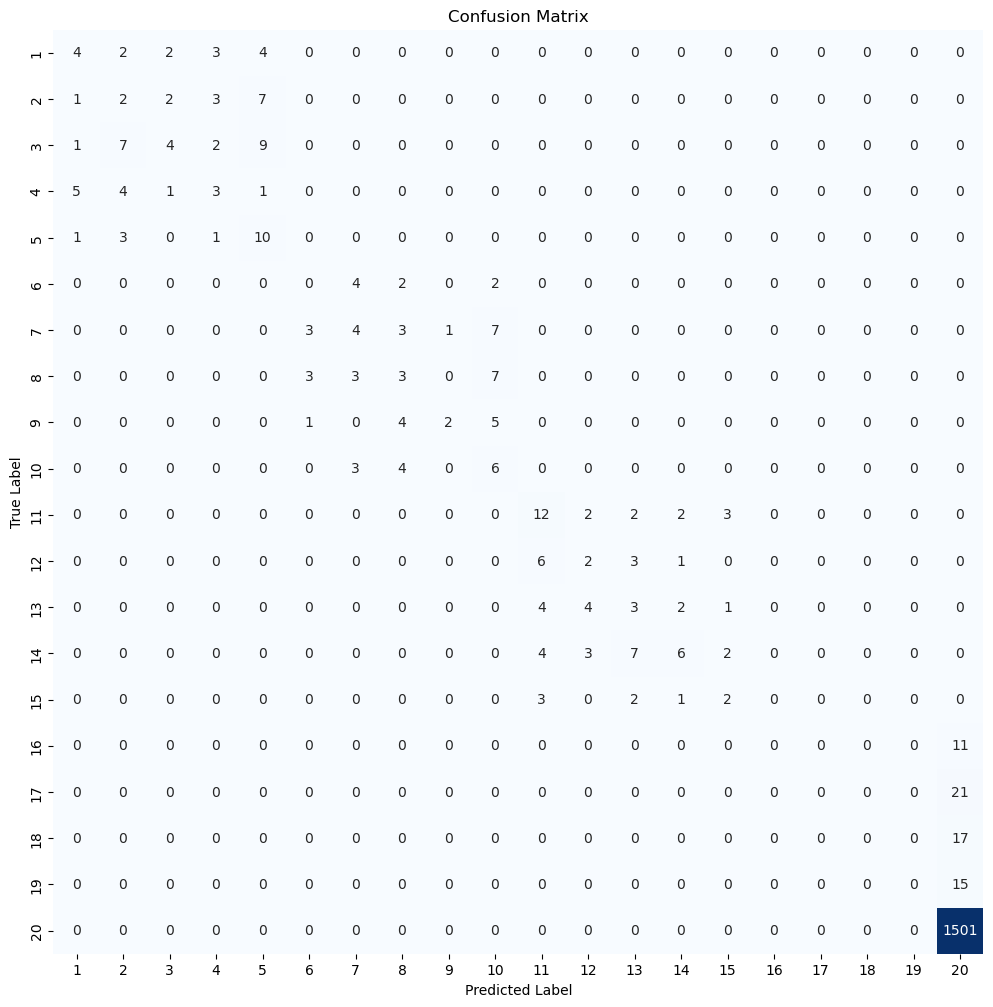

In [229]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(1, 21, 1), yticklabels=range(1, 21, 1))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/anly501/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Accuracy: 0.8492462311557789


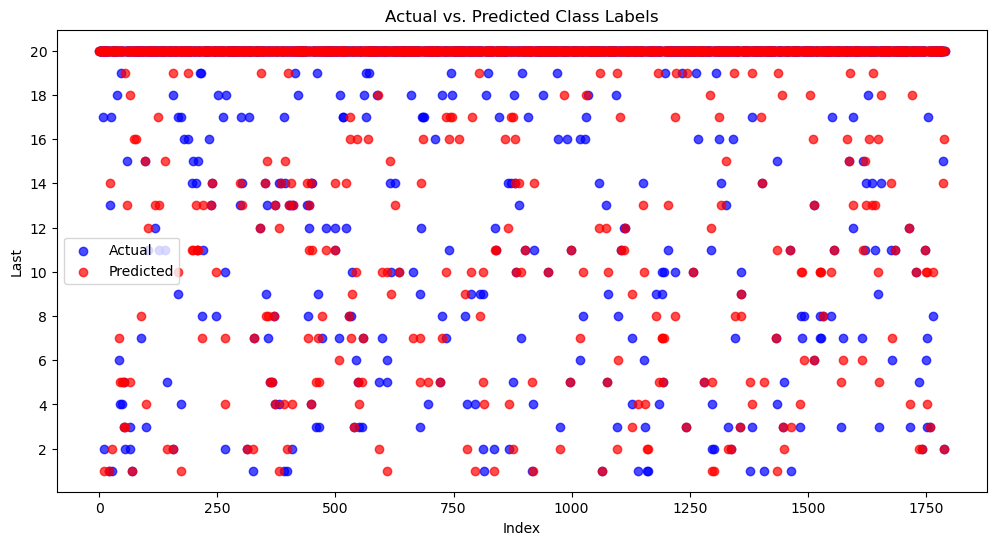

In [230]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate the accuracy for the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Create a plot to visualize the difference between actual and predicted values
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7)
plt.scatter(np.arange(len(y_test)), y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Last')
plt.title('Actual vs. Predicted Class Labels')
plt.legend()

# Set the y-axis ticks
plt.yticks(range(2, 21, 2))

# Display the plot
plt.show()

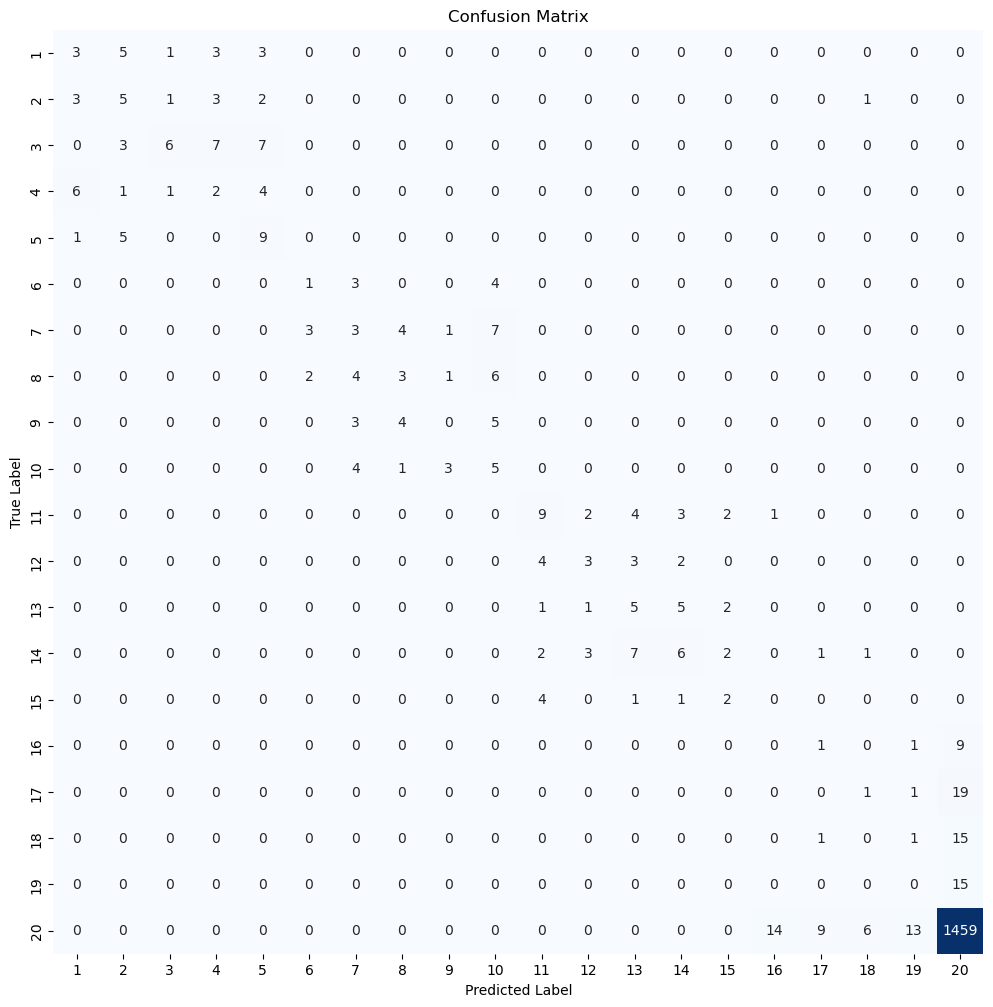

In [231]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(1, 21, 1), yticklabels=range(1, 21, 1))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Test Accuracy: 0.8514796203238414


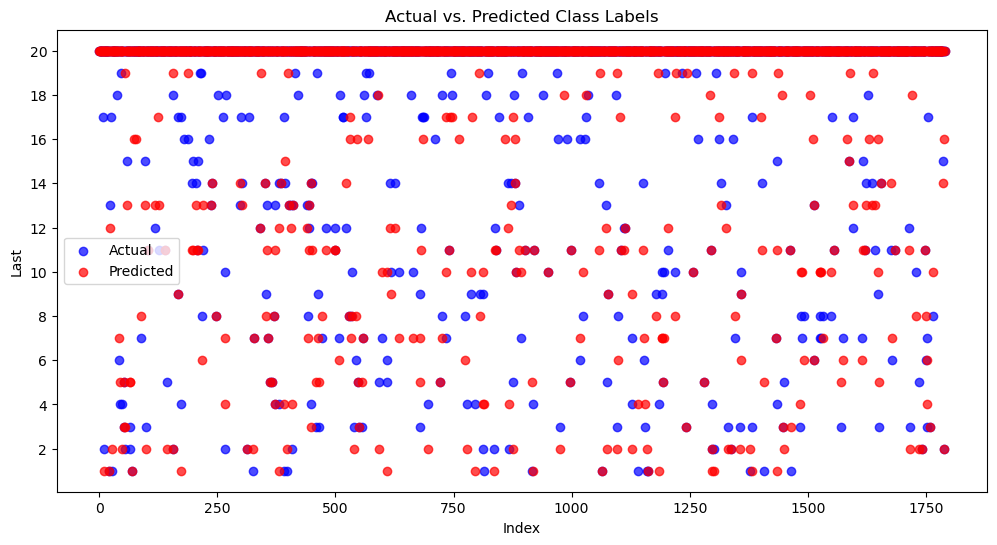

In [232]:
# Ensemble Model
y_pred = ensemble_model.predict(X_test)

# Calculate the accuracy for the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Create a plot to visualize the difference between actual and predicted values
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7)
plt.scatter(np.arange(len(y_test)), y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Last')
plt.title('Actual vs. Predicted Class Labels')
plt.legend()

# Set the y-axis ticks
plt.yticks(range(2, 21, 2))

# Display the plot
plt.show()

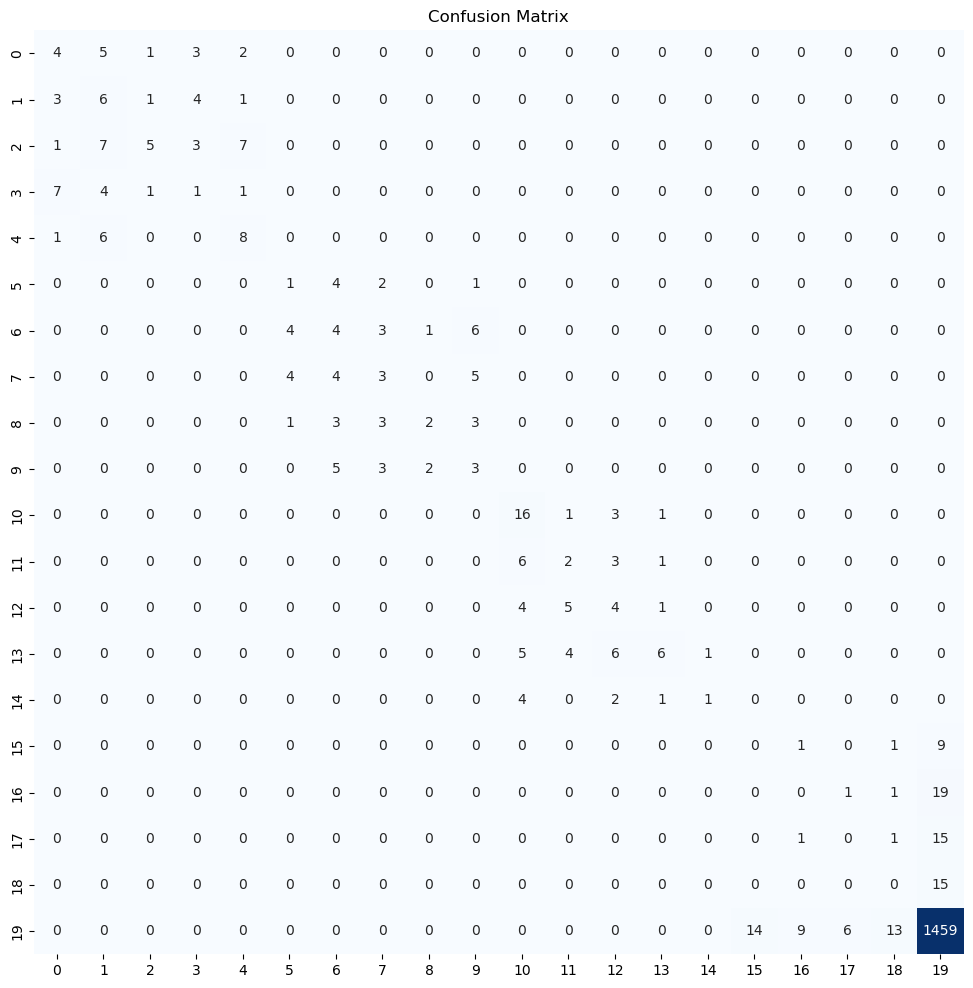

In [233]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

### Combined Model

#### Model Solely Predicting Alive/Dead

In [234]:
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(['CERT', 'last','survived'], axis=1),
                                                  train_data['survived'],
                                                  test_size=0.2, random_state=42)

# Define the base models
base_models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(random_state=42)
}

# Train and evaluate the base models
accuracy_results = {}
for model_name, model in base_models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    # Store the results
    accuracy_results[model_name] = accuracy

selected_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Create an ensemble model using the VotingClassifier
ensemble_model = VotingClassifier(estimators=list(selected_models.items()), n_jobs=-1)
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
accuracy_results["Ensemble Model"] = accuracy

# Compare the models' accuracies
print("Accuracies:")
for model_name, accuracy in accuracy_results.items():
    print(f"{model_name}: {accuracy}")

/opt/homebrew/Caskroom/miniforge/base/envs/anly501/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracies:
Logistic Regression: 0.9546406140963015
Decision Tree: 0.9267271458478716
Random Forest: 0.9713886950453594
Gradient Boosting: 0.9713886950453594
SVC: 0.8722958827634334
Ensemble Model: 0.9713886950453594


Test Accuracy: 0.9631490787269682


[Text(0.5, 1.0, 'CFM, Survived')]

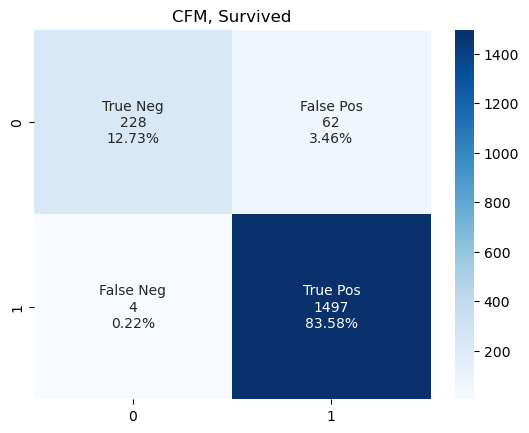

In [235]:
X_test = test_data.drop(['CERT','survived','last'], axis=1)
y_test = test_data[['survived']]

# Ensemble Model
y_pred = ensemble_model.predict(X_test)

# Calculate the accuracy for the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

plot_matrix(y_test,y_pred,"CFM, Survived")

#### Model Dealing How Long the Banks Last
Will remove `last == 20` to make the model more accurate.

In [236]:
alt_train_data = train_data[train_data['survived'] == False]
alt_test_data = test_data[test_data['survived'] == False]

In [237]:
alt_X_train, alt_X_val, alt_y_train, alt_y_val = train_test_split(alt_train_data.drop(['CERT', 'last','survived'], axis=1),
                                                  alt_train_data['last'],
                                                  test_size=0.2, random_state=42)

alt_X_test = alt_test_data.drop(['CERT', 'survived','last'], axis=1)
alt_y_test = alt_test_data[['last']]

##### Regressor

In [238]:
# Define the base models
base_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR":SVR()
}

# Train and evaluate the base models
mse_results = {}
for model_name, model in base_models.items():
    # Train the model
    model.fit(alt_X_train, alt_y_train.values.ravel())
    
    # Make predictions on the validation set
    y_pred = model.predict(alt_X_val)
    
    # Calculate the mean squared error
    mse = mean_squared_error(alt_y_val, y_pred)
    
    # Store the results
    mse_results[model_name] = mse


selected_models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Create an ensemble model using the VotingRegressor
ensemble_model = VotingRegressor(estimators=list(selected_models.items()), n_jobs=-1)
ensemble_model.fit(alt_X_train, alt_y_train.values.ravel())
y_pred = ensemble_model.predict(alt_X_val)
mse = mean_squared_error(alt_y_val, y_pred)
mse_results["Ensemble Model"] = mse

# Compare the models' MSEs
print("Mean Squared Errors:")
for model_name, mse in mse_results.items():
    print(f"{model_name}: {mse}")


Mean Squared Errors:
Linear Regression: 37.46089402664397
Decision Tree: 3.5427350427350426
Random Forest: 2.0526290598290595
Gradient Boosting: 1.9085667326829958
SVR: 21.31781994141074
Ensemble Model: 1.9349938551136039


Test Accuracy: 0.2517241379310345


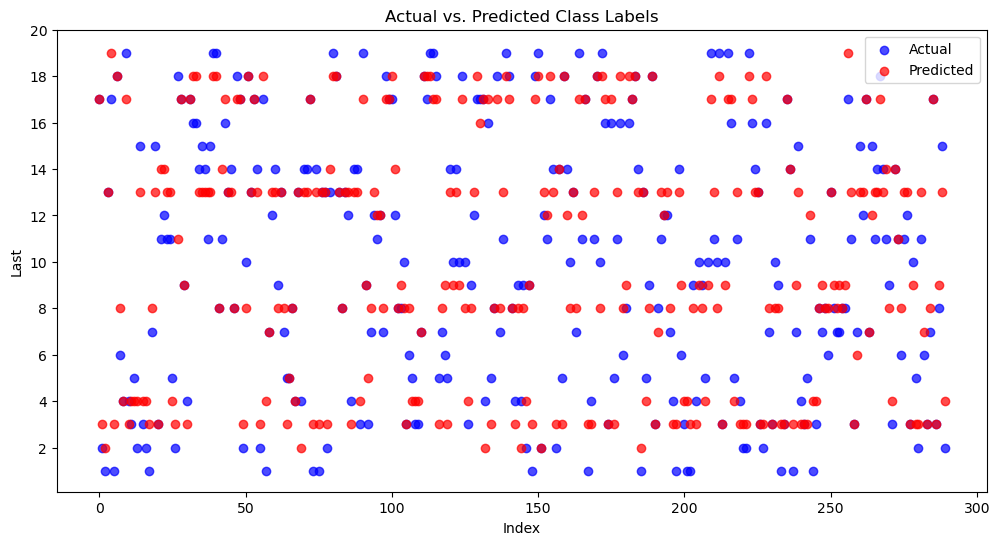

In [239]:
# Use the best model to make predictions on the test data
best_model = ensemble_model
y_pred = best_model.predict(alt_X_test)
y_pred = [round(i) for i in y_pred]

# Calculate the accuracy for the test data
test_accuracy = accuracy_score(alt_y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Create a plot to visualize the difference between actual and predicted values
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(alt_y_test)), alt_y_test, label='Actual', color='blue', alpha=0.7)
plt.scatter(np.arange(len(alt_y_test)), y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Last')
plt.title('Actual vs. Predicted Class Labels')
plt.legend()

# Set the y-axis ticks
plt.yticks(range(2, 21, 2))

# Display the plot
plt.show()

##### Classifier

In [240]:
# Define the base models
base_models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(random_state=42)
}

# Train and evaluate the base models
accuracy_results = {}
for model_name, model in base_models.items():
    # Train the model
    model.fit(alt_X_train, alt_y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(alt_X_val)
    
    # Calculate the accuracy
    accuracy = accuracy_score(alt_y_val, y_pred)
    
    # Store the results
    accuracy_results[model_name] = accuracy

selected_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Create an ensemble model using the VotingClassifier
ensemble_model = VotingClassifier(estimators=list(selected_models.items()), n_jobs=-1)
ensemble_model.fit(alt_X_train, alt_y_train)
y_pred = ensemble_model.predict(alt_X_val)
accuracy = accuracy_score(alt_y_val, y_pred)
accuracy_results["Ensemble Model"] = accuracy

# Compare the models' accuracies
print("Accuracies:")
for model_name, accuracy in accuracy_results.items():
    print(f"{model_name}: {accuracy}")

/opt/homebrew/Caskroom/miniforge/base/envs/anly501/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracies:
Logistic Regression: 0.2264957264957265
Decision Tree: 0.26495726495726496
Random Forest: 0.26495726495726496
Gradient Boosting: 0.2606837606837607
SVC: 0.10683760683760683
Ensemble Model: 0.2692307692307692


Test Accuracy: 0.2689655172413793


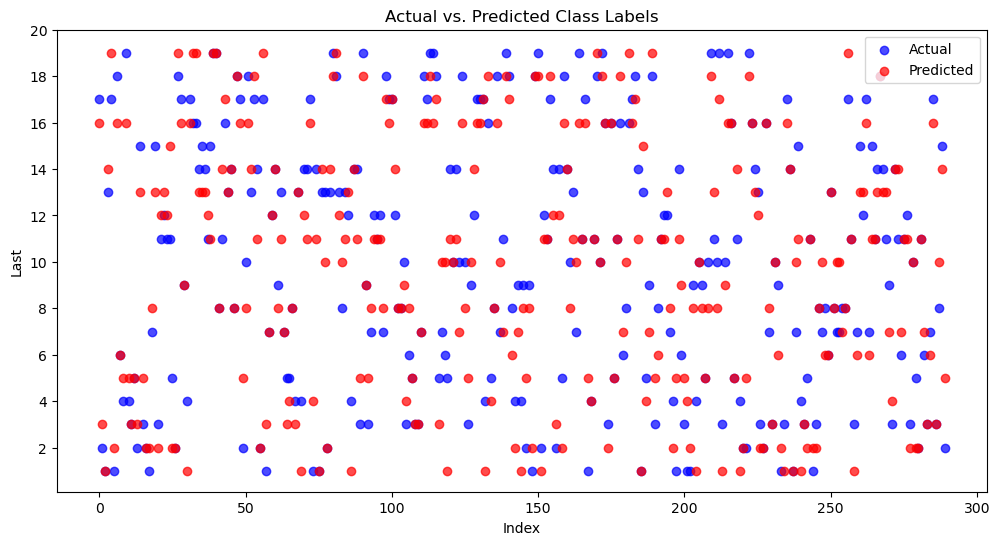

In [241]:
# Use the best modelto make predictions on the test data
best_model = ensemble_model
y_pred = best_model.predict(alt_X_test)

# Calculate the accuracy for the test data
test_accuracy = accuracy_score(alt_y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Create a plot to visualize the difference between actual and predicted values
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(alt_y_test)), alt_y_test, label='Actual', color='blue', alpha=0.7)
plt.scatter(np.arange(len(alt_y_test)), y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Last')
plt.title('Actual vs. Predicted Class Labels')
plt.legend()

# Set the y-axis ticks
plt.yticks(range(2, 21, 2))

# Display the plot
plt.show()

#### Final Model

In [242]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

class MergedModel:
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2

    def fit(self, X1, y1, X2, y2):
        self.model1.fit(X1, y1)
        self.model2.fit(X2, y2)

    def predict(self, X):
        y1_pred = self.model1.predict(X)
        y2_pred = self.model2.predict(X[y1_pred == False])
        
        final_pred = np.zeros(X.shape[0])
        final_pred[y1_pred == True] = 20
        final_pred[y1_pred == False] = y2_pred

        return final_pred

X1_train = train_data.drop(['CERT', 'last','survived'], axis=1)
y1_train = train_data['survived']
X2_train = train_data.drop(['CERT', 'last','survived'], axis=1)
y2_train = train_data['last']

selected_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Initialize the two RandomForestClassifier models
model1 = VotingClassifier(estimators=list(selected_models.items()), n_jobs=-1)
model2 = VotingClassifier(estimators=list(selected_models.items()), n_jobs=-1)

# Create and fit the merged model
merged_model = MergedModel(model1, model2)
merged_model.fit(X1_train, y1_train, X2_train, y2_train)



Test Accuracy: 0.8721384701284198


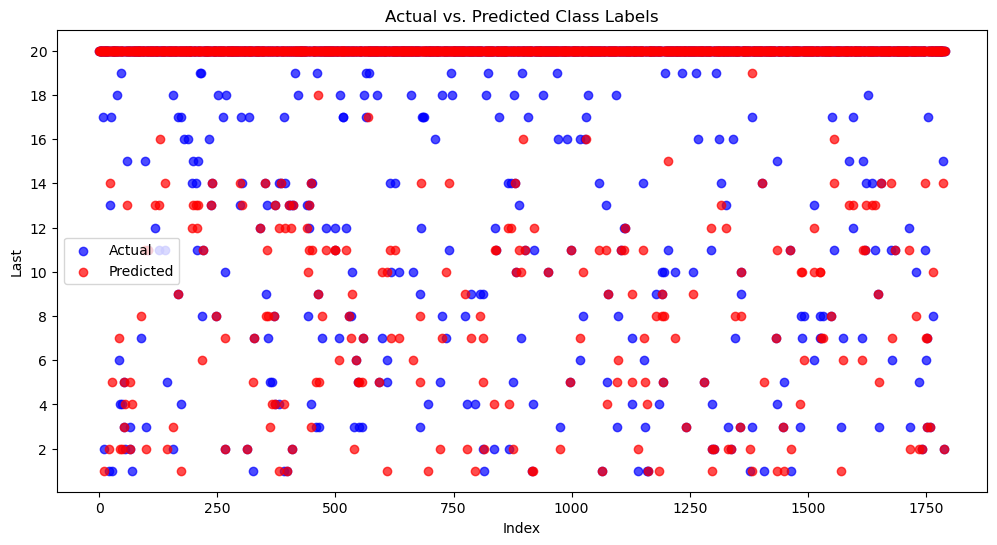

In [243]:
X_test = test_data.drop(['CERT','survived','last'], axis=1)
y_test = test_data[['last']]

y_pred = merged_model.predict(X_test)
# Calculate the accuracy for the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Create a plot to visualize the difference between actual and predicted values
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7)
plt.scatter(np.arange(len(y_test)), y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Last')
plt.title('Actual vs. Predicted Class Labels')
plt.legend()

# Set the y-axis ticks
plt.yticks(range(2, 21, 2))

# Display the plot
plt.show()

Weighted Precision: 0.843575610126894
Weighted Recall: 0.8721384701284198
Weighted F1-score: 0.8557448166181753


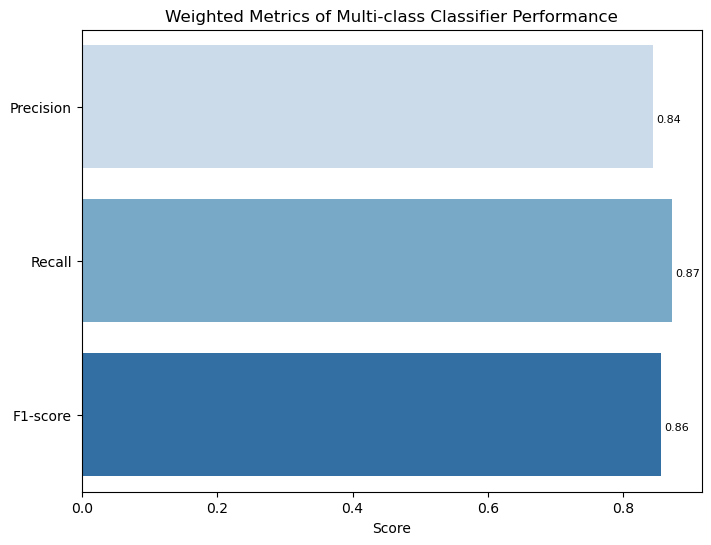

In [263]:
# Calculate Weighted Precision, Recall, and F1-score
precision_weighted, recall_weighted, f1_score_weighted, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print("Weighted Precision:", precision_weighted)
print("Weighted Recall:", recall_weighted)
print("Weighted F1-score:", f1_score_weighted)

# Plot Weighted Precision, Recall, and F1-score
plt.figure(figsize=(8, 6))
metrics = ['Precision', 'Recall', 'F1-score']
values_weighted = [precision_weighted, recall_weighted, f1_score_weighted]

ax = sns.barplot(x=values_weighted, y=metrics, palette='Blues')

# Add metric values on the right side of the bars
for i, v in enumerate(values_weighted):
    ax.text(v+0.005, i + 0.1, f"{v:.2f}", fontsize=8)

plt.xlabel('Score')
plt.title('Weighted Metrics of Multi-class Classifier Performance')
plt.show()

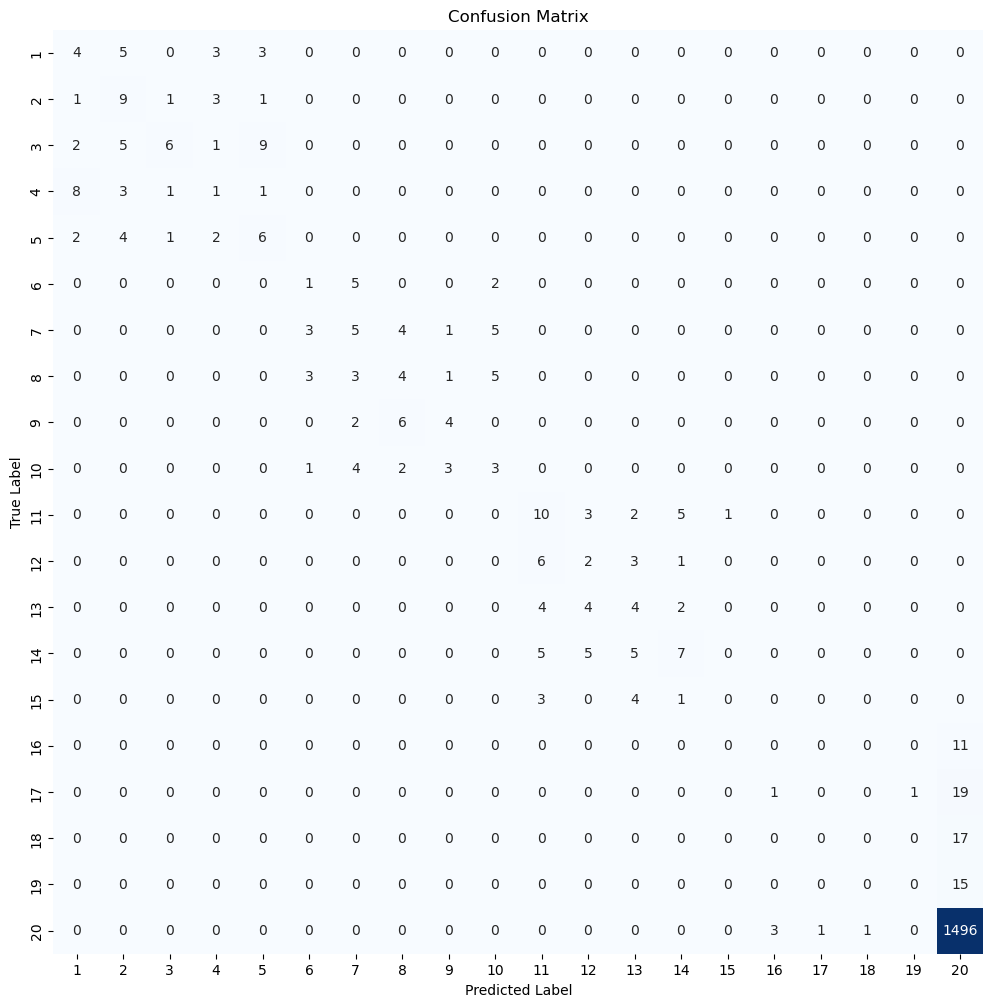

In [244]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(1, 21, 1), yticklabels=range(1, 21, 1))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()